In [7]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [8]:
# LOAD ROBOT
robot = loadKinton()
robot.initViewer(loadModel=True)
rmodel = robot.model

q0 = rmodel.referenceConfigurations["centered"]
robot.display(q0)
robot.framesForwardKinematics(q0)

In [9]:
rmodel.defaultState


AttributeError: 'Model' object has no attribute 'defaultState'

In [35]:
# DEFINE TARGET POSITION
target_pos  = np.array([0,0,1])
[ -0.7071068, 0, 0.7071068, 0 ]
target_quat = pin.Quaternion(-1, 0, 1, 0)
target_quat = pin.Quaternion(1, 0, 0, 0)
target_quat.normalize()

# Plot goal frame
robot.viewer.gui.addXYZaxis('world/framegoal', [1., 0., 0., 1.], .015, 4)
robot.viewer.gui.applyConfiguration('world/framegoal', target_pos.tolist() + [target_quat[0], target_quat[1], target_quat[2], target_quat[3]])
robot.viewer.gui.refresh()

In [36]:
# ACTUATION MODEL
distanceRotorCOG = 0.1525
cf = 6.6e-5
cm = 1e-6
actModel = ActuationModelUAM(robot.model, distanceRotorCOG, cf, cm)

# COST MODEL
# Create a cost model per the running and terminal action model.
runningCostModel = CostModelSum(robot.model, actModel.nu)
terminalCostModel = CostModelSum(robot.model, actModel.nu)

frameName = 'link6'
state = StatePinocchio(robot.model)
SE3ref = pin.SE3()
SE3ref.translation = target_pos.reshape(3,1)
SE3ref.rotation = target_quat.matrix()


wBasePos  = [1]
wBaseOri  = [1]
wArmPos   = [1]
wBaseVel  = [10]
wBaseRate = [10]
wArmVel   = [10] 
stateWeights   = np.array(wBasePos * 3 + wBaseOri * 3 + wArmPos * (robot.model.nv - 6) + wBaseVel * robot.model.nv)
controlWeights = np.array([0.1]*4 + [100]*6)

goalTrackingCost = CostModelFramePlacement(rmodel,
                                           frame=rmodel.getFrameId(frameName),
                                           ref=SE3ref,
                                           nu =actModel.nu)

xRegCost = CostModelState(rmodel, 
                          state, 
                          ref=state.zero(), 
                          nu=actModel.nu,
                          activation=ActivationModelWeightedQuad(stateWeights))
uRegCost = CostModelControl(rmodel, 
                            nu=robot.
                            model.nv-2,
                            activation = ActivationModelWeightedQuad(controlWeights))
uLimCost = CostModelControl(rmodel, 
                            nu=robot.
                            model.nv-2,
                            activation = ActivationModelInequality(np.array([0.1, 0.1, 0.1, 0.1, -1, -1, -1, -1, -1, -1]), 
                                                                np.array([5, 5, 5, 5, 1, 1, 1, 1, 1, 1])))

# Then let's add the running and terminal cost functions
runningCostModel.addCost(name="pos", weight=0.1, cost=goalTrackingCost)
runningCostModel.addCost(name="regx", weight=1e-4, cost=xRegCost)
runningCostModel.addCost(name="regu", weight=1e-6, cost=uRegCost)
runningCostModel.addCost(name="limu", weight=1e-2, cost=uLimCost)
terminalCostModel.addCost(name="pos", weight=5, cost=goalTrackingCost)

# DIFFERENTIAL ACTION MODEL
runningModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, runningCostModel))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, terminalCostModel))

In [37]:
# DEFINING THE SHOOTING PROBLEM & SOLVING
# Defining the time duration for running action models and the terminal one
dt = 5e-2
runningModel.timeStep = dt

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = int(1/dt)
q0 = rmodel.referenceConfigurations["centered"].copy()
v0 = pin.utils.zero(rmodel.nv)
x0 = m2a(np.concatenate([q0, v0]))
rmodel.defaultState = x0.copy()

problem = ShootingProblem(x0, [runningModel] * T, terminalModel)

# Creating the DDP solver for this OC problem, defining a logger
fddp = SolverFDDP(problem)
fddp.callback = [CallbackDDPVerbose()]
fddp.callback.append(CallbackDDPLogger())

us0 = [
    m.differential.quasiStatic(d.differential, rmodel.defaultState)
    if isinstance(m, IntegratedActionModelEuler) else np.zeros(0)
    for m, d in zip(fddp.problem.runningModels, fddp.problem.runningDatas)]
xs0 = [problem.initialState]*len(fddp.models())

# Solving it with the DDP algorithm
#fddp.solve(init_xs=xs0, init_us=us0)
fddp.solve()

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  1.69470e+00  3.76618e-01  2.17448e+01  1.00000e-09  1.00000e-09   0.5000     0
   1  1.57516e+00  1.32234e-04  3.27743e+00  1.00000e-09  1.00000e-09   0.0625     0
   2  1.40857e+00  1.44596e-03  2.92461e+00  1.00000e-09  1.00000e-09   0.0625     0
   3  1.31015e+00  1.23631e-03  2.48624e+00  1.00000e-09  1.00000e-09   0.1250     0
   4  1.20843e+00  4.22214e-03  2.12939e+00  1.00000e-09  1.00000e-09   0.1250     0
   5  1.13694e+00  5.55300e-03  1.79589e+00  1.00000e-09  1.00000e-09   0.1250     0
   6  1.08536e+00  6.39530e-03  1.54614e+00  1.00000e-09  1.00000e-09   0.1250     0
   7  1.03600e+00  6.92438e-03  1.35711e+00  1.00000e-09  1.00000e-09   0.1250     0
   8  9.77145e-01  7.06627e-03  1.19248e+00  1.00000e-09  1.00000e-09   0.1250     0
   9  9.09731e-01  6.75431e-03  1.02581e+00  1.00000e-09  1.00000e-09   0.1250     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  8.80585e

([array([0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0.2, 1.7, 2. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]),
  array([ 9.15453549e-07, -8.17547458e-08,  1.30947392e-02,  8.35006620e-06,
          8.60137935e-05, -4.24374481e-06,  9.99999996e-01, -1.50043464e-05,
          1.99911457e-01,  1.70000828e+00,  1.99669663e+00,  4.01452361e-03,
         -3.76771300e-04, -4.21748902e-06,  5.51789701e-07,  2.61894784e-01,
          3.34002649e-04,  3.44055174e-03, -1.69749792e-04, -3.00086928e-04,
         -1.77085415e-03,  1.65524087e-04, -6.60674902e-02,  8.02904722e-02,
         -7.53542600e-03]),
  array([ 8.44458709e-06, -7.91156753e-07,  3.83889211e-02,  1.31431254e-05,
          1.39726592e-04, -5.60633936e-06,  9.99999990e-01, -3.89457229e-05,
          1.99779194e-01,  1.69955747e+00,  1.99323578e+00,  7.59111178e-03,
         -7.10822661e-04,  3.63843869e-05, -3.31405886e-06,  5.05883660e-01,
          1.91717941e-04,  2.14851230e-03, -5.45052325e-0

In [41]:
displayTrajectory(robot, fddp.xs, runningModel.timeStep)

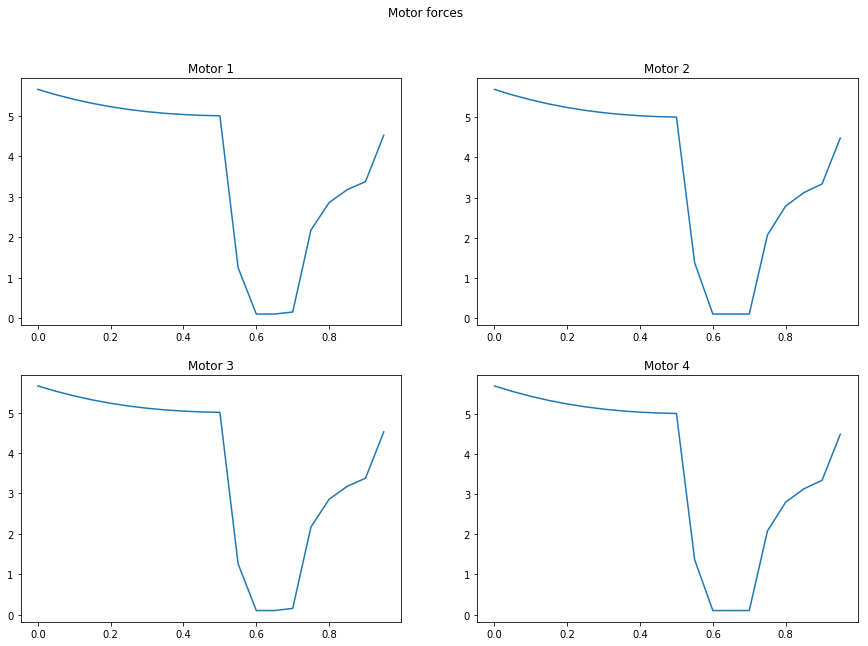

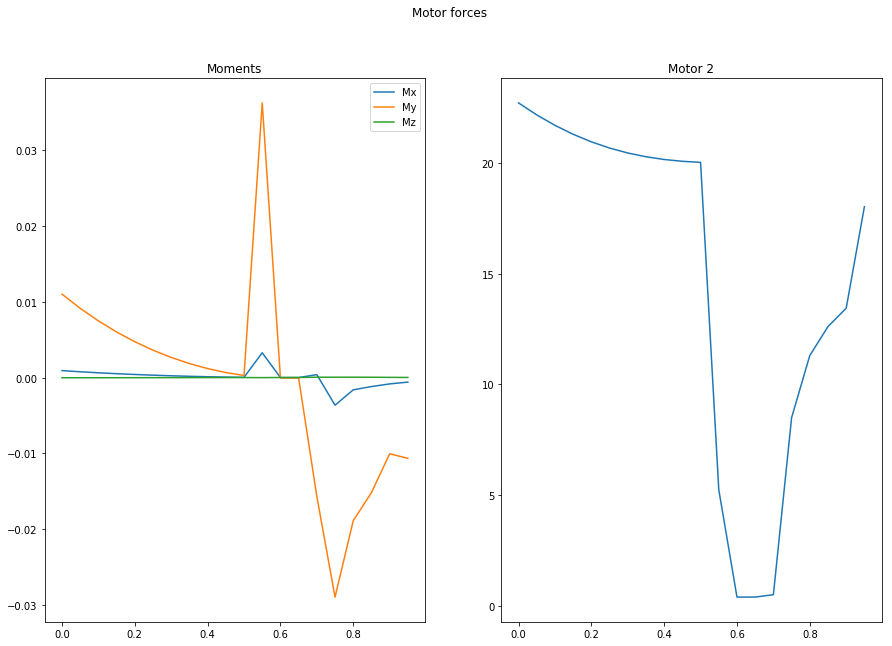

In [44]:
pltUAM = PlotUAM(fddp.xs, fddp.us, T, dt, distanceRotorCOG, cf, cm)

fig, axs = pltUAM.plotMotorForces()
fig,axs = pltUAM.plotActuation()